## Import required modules

In [1]:
# this is for the jupyter notebook at JupyterLab
# to make sys.path between the terminal and Jupyter same
import sys

print(sys.path) # especially the path to site-packages are different... so thats why couldn't find correct package...

# remove weird paths...
sys.path = sys.path[:4]+[sys.path[6]]
print(sys.path)

['/nfs/team205/kk18/notebooks/P48_Foetal-heart_Visium/notebooks/notebooks_for_manuscript', '/nfs/team205/kk18/miniconda3/envs/cell2loc_v013_env/lib/python39.zip', '/nfs/team205/kk18/miniconda3/envs/cell2loc_v013_env/lib/python3.9', '/nfs/team205/kk18/miniconda3/envs/cell2loc_v013_env/lib/python3.9/lib-dynload', '', '/nfs/users/nfs_k/kk18/.local/lib/python3.9/site-packages', '/nfs/team205/kk18/miniconda3/envs/cell2loc_v013_env/lib/python3.9/site-packages']
['/nfs/team205/kk18/notebooks/P48_Foetal-heart_Visium/notebooks/notebooks_for_manuscript', '/nfs/team205/kk18/miniconda3/envs/cell2loc_v013_env/lib/python39.zip', '/nfs/team205/kk18/miniconda3/envs/cell2loc_v013_env/lib/python3.9', '/nfs/team205/kk18/miniconda3/envs/cell2loc_v013_env/lib/python3.9/lib-dynload', '/nfs/team205/kk18/miniconda3/envs/cell2loc_v013_env/lib/python3.9/site-packages']


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
# enables correct plotting of text
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42 
import seaborn as sns
import os 
from mpl_toolkits.axes_grid1 import make_axes_locatable

from cell2location.plt import plot_spatial

/nfs/team205/kk18/miniconda3/envs/cell2loc_v013_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 0
/nfs/team205/kk18/miniconda3/envs/cell2loc_v013_env/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/nfs/team205/kk18/miniconda3/envs/cell2loc_v013_env/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The i

In [3]:
import session_info
session_info.show()

In [4]:
sc.settings.set_figure_params(dpi=80,dpi_save=300)

In [5]:
figdir = '/nfs/team205/heart/fetal_ms_figures/raw_plots_kk'

## Prepare functions

In [6]:
# This function selects the data for multiple slides from the spatial anndata object.
# Modified `select_slide` in cell2loc for multiple slides

# @param adata: anndata object with multiple spatial experiments
# @param s: list of selected slides
# @param s_col: column in adata.obs listing experiment name for each location

def select_multislide(adata, s, s_col='sample'):

    slides = adata[adata.obs[s_col].isin(s), :]
    s_keys = list(slides.uns['spatial'].keys())
    
    uns_dict = {}
    for ss in s:
        s_spatial=np.array(s_keys)[[ss in k for k in s_keys]][0]
        uns_dict[s_spatial]=slides.uns['spatial'][s_spatial]
    
    slides.uns['spatial'] = uns_dict

    return slides

In [44]:
from matplotlib_scalebar.scalebar import ScaleBar
def get_pixel_size_visium(adata, library_id, spot_diameter_real = 55, img='hires'):
    '''
    Utility function to get size of pixels from visium image in AnnData.
    Useful to plot scalebars with matplotlib_scalebar.ScaleBar
    
    Params:
    -------
    - adata: AnnData object storing image info in adata.uns[spatial]
    - library_id: string storing ID for image, must be a key in adata.uns[spatial]
    - spot_diameter_real: numeric storing real diameter of spot, in whatever unit you need 
        (default is 55, for 55 microns of Visium 10X spots)
    - img: which image to use (default: lowres)
    '''

    ## get scale factor converting original pixel positions (adata.obsm['spatial']) to 
    # pixel positions in image
    scalef = adata.uns['spatial'][library_id]['scalefactors']['tissue_{i}_scalef'.format(i=img)]
    ## get spot diameter in image pixels
    spot_diameter_img = adata.uns['spatial'][library_id]['scalefactors']['spot_diameter_fullres'] * scalef
    ## Calculate pixel size
    pixel_size_real = spot_diameter_real/spot_diameter_img
    return(pixel_size_real)


## Read in anndata

In [7]:
adata_ffpe = sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/visium-FFPE_foetal_raw.h5ad')

# add abundance to .obs
df = adata_ffpe.obsm['q05_cell_abundance_w_sf'].copy()
## rename columns
df.columns = [x.replace('q05cell_abundance_w_sf_','') for x in df.columns]
adata_ffpe.obs[df.columns]=df.copy()

# set symboßl as var_names
adata_ffpe.var.set_index('SYMBOL',inplace=True)
adata_ffpe

AnnData object with n_obs × n_vars = 19973 × 18085
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'sangerID', 'Publication', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'status', 'JC_edit', 'AtrialCardiomyocytesLeft', 'AtrialCardiomyocytesRight', 'VentricularCardiomyocytesLeftCompact', 'VentricularCardiomyocytesRightCompact', 'VentricularCardiomyocytesLeftTrabeculated', 'VentricularCardiomyocytesRightTrabeculated', 'SinoatrialNodeCardiomyocytes', 'AtrioventricularNodeCardiomyocytes', 'VentricularConductionSystemProximal', 'VentricularConductionSystemDistal', 'GreatVesselAdventitialFibroblasts', 'CoronaryVesselAdventitialFibroblasts', 'MyocardialInterstitialFib

In [8]:
adata_oct = sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/visium-OCT_foetal_raw.h5ad')

# add abundance to .obs
df = adata_oct.obsm['q05_cell_abundance_w_sf'].copy()
## rename columns
df.columns = [x.replace('q05cell_abundance_w_sf_','') for x in df.columns]
adata_oct.obs[df.columns]=df.copy()

# set symboßl as var_names
adata_oct.var.set_index('SYMBOL',inplace=True)
adata_oct

AnnData object with n_obs × n_vars = 14261 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'sangerID', 'Publication', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'status', 'cell2loc-map_group', 'JC_edit', 'sample_for_cell2loc', 'AtrialCardiomyocytesLeft', 'AtrialCardiomyocytesRight', 'VentricularCardiomyocytesLeftCompact', 'VentricularCardiomyocytesRightCompact', 'VentricularCardiomyocytesLeftTrabeculated', 'VentricularCardiomyocytesRightTrabeculated', 'SinoatrialNodeCardiomyocytes', 'AtrioventricularNodeCardiomyocytes', 'VentricularConductionSystemProximal', 'VentricularConductionSystemDistal', 'GreatVesselAdventitialFibroblasts', 'CoronaryVesselAdvent

In [9]:
adata_oct_20pcw = sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/visium-OCT-LV_foetal_raw.h5ad')

# add abundance to .obs
df = adata_oct_20pcw.obsm['q05_cell_abundance_w_sf'].copy()
## rename columns
df.columns = [x.replace('q05cell_abundance_w_sf_','') for x in df.columns]
adata_oct_20pcw.obs[df.columns]=df.copy()

# set symboßl as var_names
adata_oct_20pcw.var.set_index('SYMBOL',inplace=True)
adata_oct_20pcw

AnnData object with n_obs × n_vars = 6767 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'sangerID', 'Publication', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'status', 'cell2loc-map_group', 'JC_edit', 'sample_for_cell2loc', 'VentricularCardiomyocytesLeftCompact', 'VentricularCardiomyocytesLeftTrabeculated', 'VentricularConductionSystemProximal', 'VentricularConductionSystemDistal', 'CoronaryVesselAdventitialFibroblasts', 'MyocardialInterstitialFibroblasts1', 'MyocardialInterstitialFibroblasts2', 'Myofibroblasts', 'LymphNodeFibroblasticReticularCells', 'CoronarySmoothMuscleCells', 'CoronaryPericytes', 'CoronaryArterialEndothelialCells', 'CoronaryVenou

# Plot the uncropped section

In [74]:
slide_ids = {
    '5PCW':'HCAHeartST11605168',
    '7PCW':'HCAHeartST10317185',
    '13PCW':'HCAHeartST11605165',
    '16PCW':'BHF_F_Hea13295830', # FFPE
    '20PCW':'HCAHeartST13162330'
}

/tmp/ipykernel_108365/2805736760.py:18: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  slides.uns['spatial'] = uns_dict


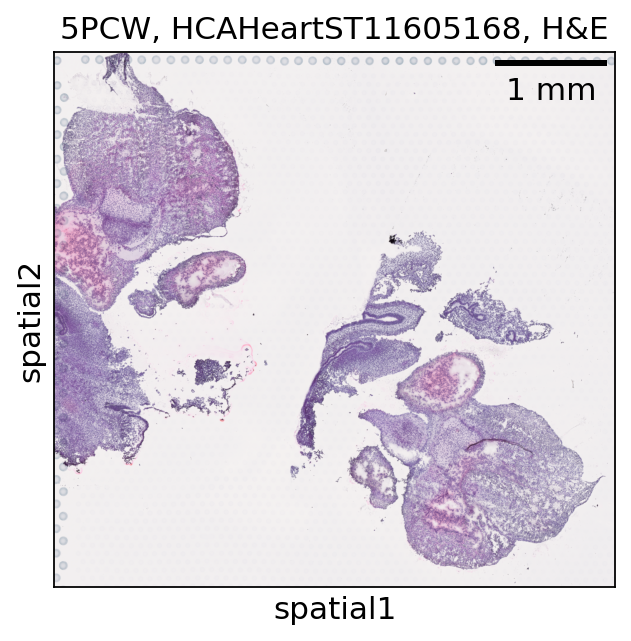

/tmp/ipykernel_108365/2805736760.py:18: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  slides.uns['spatial'] = uns_dict


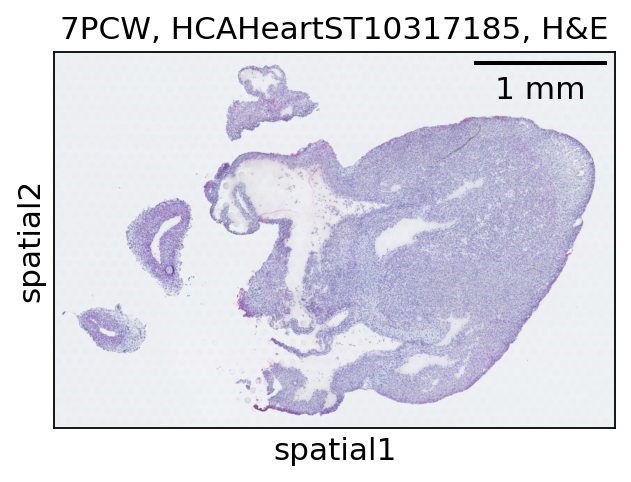

/tmp/ipykernel_108365/2805736760.py:18: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  slides.uns['spatial'] = uns_dict


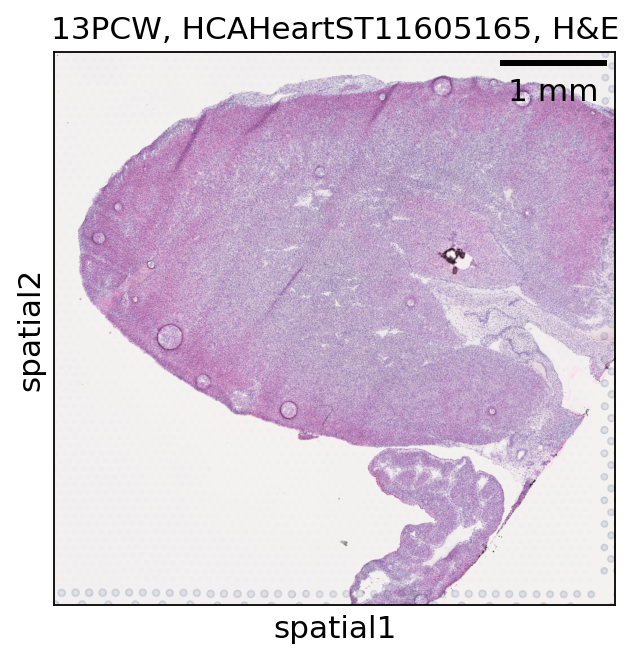

/tmp/ipykernel_108365/2805736760.py:18: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  slides.uns['spatial'] = uns_dict


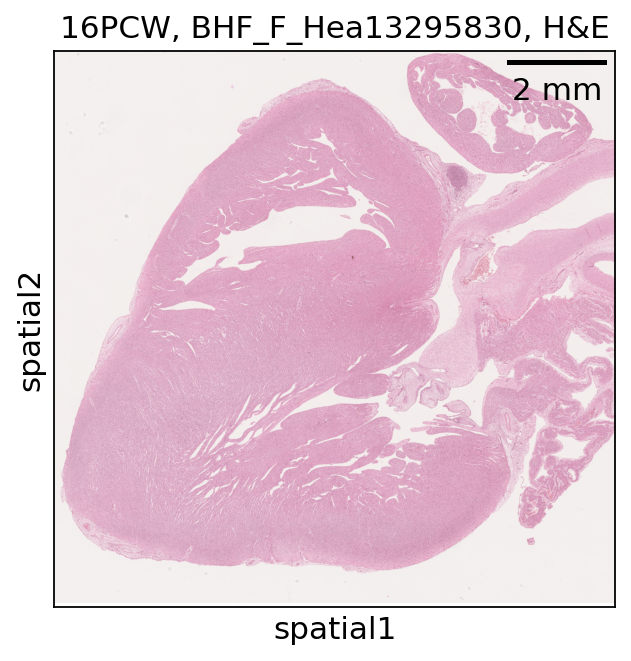

/tmp/ipykernel_108365/2805736760.py:18: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  slides.uns['spatial'] = uns_dict


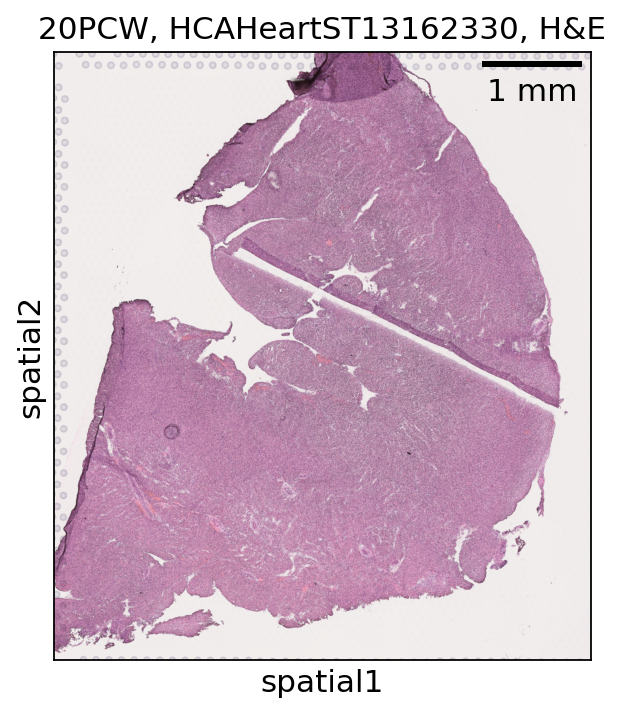

In [75]:
for week,slide_id in slide_ids.items():
    if week=='16PCW':
        slide = select_multislide(adata_ffpe, [slide_id])
        slide_copy = slide.copy()
        slide.uns['spatial'] = {}
        slide.uns['spatial'][slide_id] = [slide_copy.uns['spatial'][x] for x in slide_copy.uns['spatial'].keys() if slide_id in x][0]
    elif week=='20PCW':
        slide = select_multislide(adata_oct_20pcw, [slide_id])
    else:
        slide = select_multislide(adata_oct, [slide_id])
    
    # get pixel size
    pix_size = get_pixel_size_visium(slide, slide_id, spot_diameter_real = 55)
        
    with mpl.rc_context({#'axes.facecolor':  'black',
                         'figure.figsize': [4.5, 5]}):
        fig, ax = plt.subplots()
        sc.pl.spatial(slide, cmap='RdPu',
                      color=['JC_edit'], 
                      ncols=5, size=0, 
                      img_key='hires', alpha_img=1,wspace=0.3,
                      vmin=0, vmax='p99.5',# palette=palette
                      legend_loc=None,
                      title=f'{week}, {slide_id}, H&E',
                      show=False,ax=ax
                     )
        scalebar = ScaleBar(pix_size, "um", length_fraction=0.25, frameon=False, location='upper right')
        ax.add_artist(scalebar)
        plt.show()

# Add annotation

In [91]:
# read in modify annotations
adata_annot = sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/visium_foetal_healthy-all_raw.h5ad',backed='r')

# modify annotations for matching with factor analysis
annotation_edit_dict = {
   'AV valves':'Valves',
    'Aortic valve':'Valves',
    'Valve apparatus':'Valves',
    'Atrium - Left':'Atrium',
     'Atrium - Right':'Atrium',
    'Ventricle - Compact - Left':'Ventricle - Compact',
    'Ventricle - Compact - Right':'Ventricle - Compact',
    'Ventricle - Trabeculated - Left':'Ventricle - Trabeculated',
    'Ventricle - Trabeculated - Right':'Ventricle - Trabeculated',
}
adata_annot.obs['annotation_final_mod']=adata_annot.obs['annotation_final'].astype('str').copy()
adata_annot.obs.replace({'annotation_final_mod':annotation_edit_dict}, 
                      inplace=True)
adata_annot.obs['annotation_final_mod'] = adata_annot.obs['annotation_final_mod'].astype('category')

# set palette and categorie order
AnnotationPalette={ 
    'Atrium':'#eac075',
        'Ventricle - Compact':'#f1acfa',
     'Ventricle - Trabeculated':'#f09951',
        'SAnode':'#8A2BE2',
        'AVnode':'#062b4a',
    'VCS - Proximal':'#FFFF00',
        'VCS - Distal':'#7FFFD4',
        'Epicardium':'#01ccc8',
        'Endocardium - Atrial':'#DC143C',
        'Endocardium - Ventricular':'#f53527',
        'Endocardial cusion':'#ff7e97',
        'Great vessel':'#ff9b6e',
    'Ductus arteriosus':'#8a6800',
        'Coronary vessel':'#206601',
        'Adventitia - Coronary':'#CAFF70',
     'Adventitia - GV':'#005aa0',
        'AV ring':'#e478ff',
    'Valves':'#3300FF',
    'LN':'#9088ff',
}
adata_annot.obs['annotation_final_mod'] = adata_annot.obs['annotation_final_mod'].astype('category')
adata_annot.obs['annotation_final_mod'] = adata_annot.obs['annotation_final_mod'].cat.reorder_categories(AnnotationPalette.keys())

/nfs/team205/kk18/miniconda3/envs/cell2loc_v013_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [92]:
# add
adata_ffpe.obs['annotation_final_mod'] = adata_annot.obs['annotation_final_mod'].reindex(adata_ffpe.obs_names)
adata_oct.obs['annotation_final_mod'] = adata_annot.obs['annotation_final_mod'].reindex(adata_oct.obs_names)
adata_oct_20pcw.obs['annotation_final_mod'] = adata_annot.obs['annotation_final_mod'].reindex(adata_oct_20pcw.obs_names)

# Plots for figures

* Use 5, 7, and 16PCW data
* Which has whole heart

In [76]:
slide_ids_sel = {}
for key,value in slide_ids.items():
    if key in ['5PCW','7PCW','16PCW']:
        slide_ids_sel[key] = value
slide_ids_sel

{'5PCW': 'HCAHeartST11605168',
 '7PCW': 'HCAHeartST10317185',
 '16PCW': 'BHF_F_Hea13295830'}

## HE, whole heart, with scale

In [96]:
# cropping parameters
cropp_cord_list = {
    '5PCW': [8000,14500,7800,14000],
    '7PCW': [3000,14000,7000,15000],
    '16PCW': [0,17500,500,16500],
}

/tmp/ipykernel_108365/2805736760.py:18: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  slides.uns['spatial'] = uns_dict


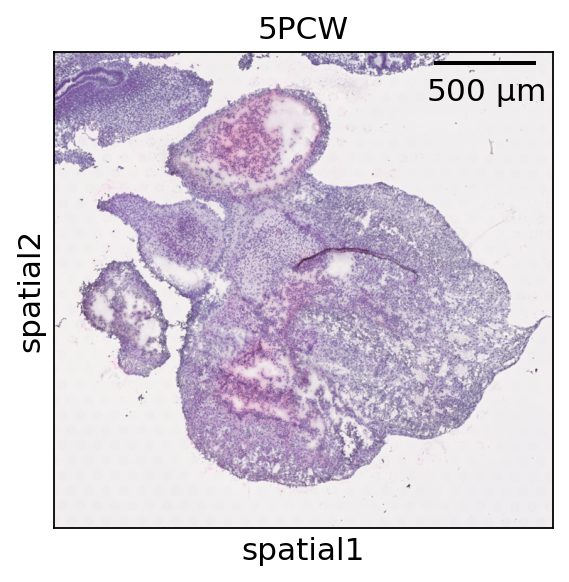

/tmp/ipykernel_108365/2805736760.py:18: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  slides.uns['spatial'] = uns_dict


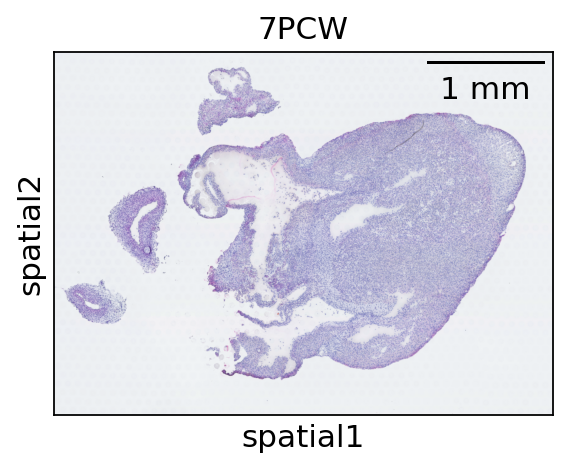

/tmp/ipykernel_108365/2805736760.py:18: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  slides.uns['spatial'] = uns_dict


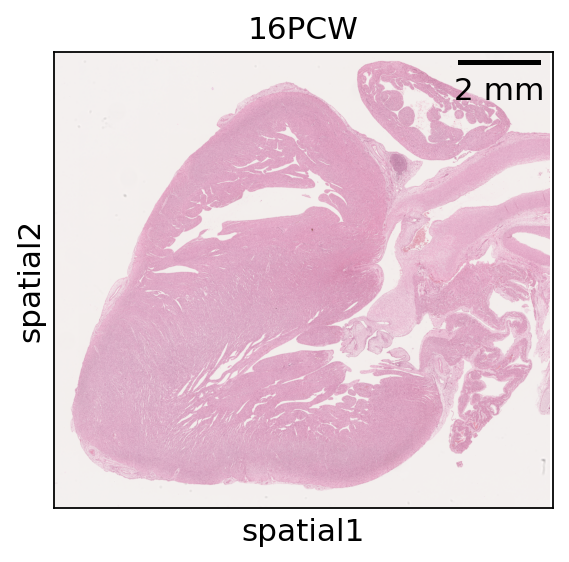

In [97]:
for week,slide_id in slide_ids_sel.items():
    if week=='16PCW':
        slide = select_multislide(adata_ffpe, [slide_id])
        slide_copy = slide.copy()
        slide.uns['spatial'] = {}
        slide.uns['spatial'][slide_id] = [slide_copy.uns['spatial'][x] for x in slide_copy.uns['spatial'].keys() if slide_id in x][0]
    else:
        slide = select_multislide(adata_oct, [slide_id])
    
    # get pixel size
    pix_size = get_pixel_size_visium(slide, slide_id, spot_diameter_real = 55)
        
    crop_coord = cropp_cord_list[week]

    # plot in spatial coordinates
    with mpl.rc_context({#'axes.facecolor':  'black',
                         #'figure.figsize': [4.5, 5]
    }):
        
        fig, ax = plt.subplots()
        sc.pl.spatial(slide, cmap='RdPu',
                      color=['JC_edit'], 
                      ncols=5, size=0, 
                      img_key='hires', alpha_img=1,wspace=0.3,
                      vmin=0, vmax='p99.5',# palette=palette
                      crop_coord = crop_coord,
                      legend_loc=None,
                      title=week,
                      show=False,ax=ax
                     )
        scalebar = ScaleBar(pix_size, "um", length_fraction=0.25, frameon=False, location='upper right')
        ax.add_artist(scalebar)
        plt.savefig(f"{figdir}/visium_temporal_HE_{slide_id}.pdf", bbox_inches="tight",dpi=300)
        plt.show()

## Tissue annotations

/tmp/ipykernel_108365/2805736760.py:18: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  slides.uns['spatial'] = uns_dict
/tmp/ipykernel_108365/2805736760.py:18: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  slides.uns['spatial'] = uns_dict
/tmp/ipykernel_108365/2805736760.py:18: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  slides.uns['spatial'] = uns_dict


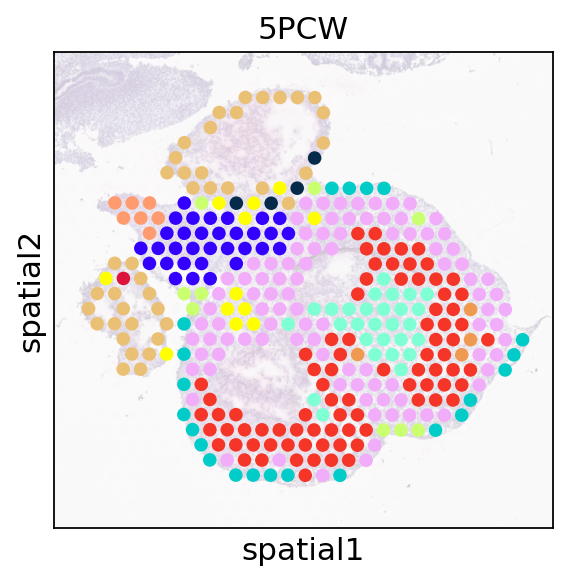

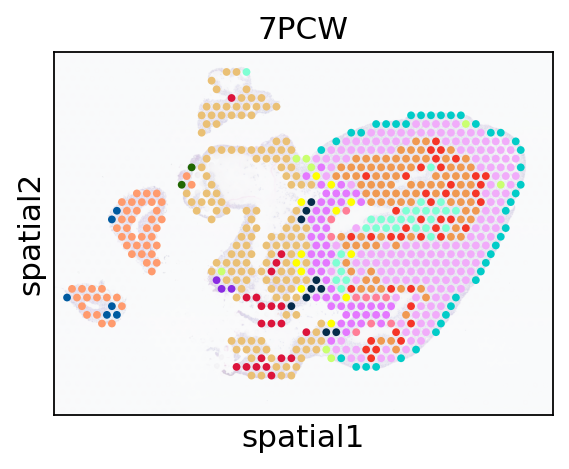

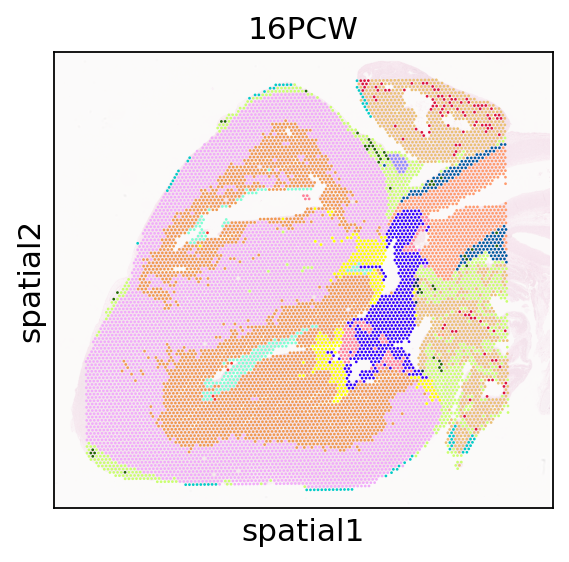

In [98]:
for week,slide_id in slide_ids_sel.items():
    if week=='16PCW':
        slide = select_multislide(adata_ffpe, [slide_id])
        slide_copy = slide.copy()
        slide.uns['spatial'] = {}
        slide.uns['spatial'][slide_id] = [slide_copy.uns['spatial'][x] for x in slide_copy.uns['spatial'].keys() if slide_id in x][0]
    else:
        slide = select_multislide(adata_oct, [slide_id])
        
    crop_coord = cropp_cord_list[week]

    # plot in spatial coordinates
    with mpl.rc_context({#'axes.facecolor':  'black',
                         #'figure.figsize': [4.5, 5]
    }):
        
        sc.pl.spatial(slide, cmap='RdPu',
                      color=['annotation_final_mod'], 
                      ncols=5, size=1.2, 
                      img_key='hires', alpha_img=0.3,wspace=0.3,
                      vmin=0, vmax='p99.5', palette=AnnotationPalette,
                      crop_coord = crop_coord,
                      legend_loc=None,
                      title=week,
                      show=False
                     )
        plt.savefig(f"{figdir}/visium_temporal_annotations_{slide_id}.pdf", bbox_inches="tight",dpi=300)